# Système de recommandation

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz     # Comparaison des string

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Utilisateur\Anaconda3\envs\Recommendation\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1.Chargement des données

In [2]:
df_ratings = pd.read_csv(
    'Reviews.csv',
    usecols=['customer', 'productId', 'rating'],
    dtype={'customer': 'int32', 'productId': 'int32', 'rating': 'float32'})

df_products = pd.read_csv(
    'Products.csv',
    usecols=['productId', 'title'],
    dtype={'productId': 'int32', 'title': 'str'})

In [3]:
df_products.head()

,productId,title
0,620,Toddler Boys Camo Print Hoodie & Sweatpants
1,619,SHEIN Girls Solid Cami Top & Belted Pants Set
2,618,SHEIN Girls Colorblock Slogan Graphic Pullover
3,617,SHEIN Girls Drop Shoulder Plaid Sweatshirt
4,616,SHEIN Girls Drop Shoulder Letter Hoodie & Camo...


In [4]:
df_ratings.head()

,customer,productId,rating
0,1,541,4.0
1,1,540,4.0
2,1,539,5.0
3,1,538,3.0
4,1,537,3.0


In [5]:
num_users = len(df_ratings.customer.unique())
num_prdts= len(df_ratings.productId.unique())
print('il y a {} utilisateurs et {} produits dans cette jeu de données'.format(num_users, num_prdts))

il y a 6 utilisateurs et 549 produits dans cette jeu de données


## 2. Analyse des données

In [6]:
# compter chaque rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1.0,341
2.0,368
3.0,335
4.0,364
5.0,373


In [7]:
# compter le nombre de rating =0
total_cnt = num_users * num_prdts
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# ajouter le nombre de rating =0 à df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()

df_ratings_cnt

,count
0.0,1513
1.0,341
2.0,368
3.0,335
4.0,364
5.0,373


Text(0, 0.5, 'nombre de rating')

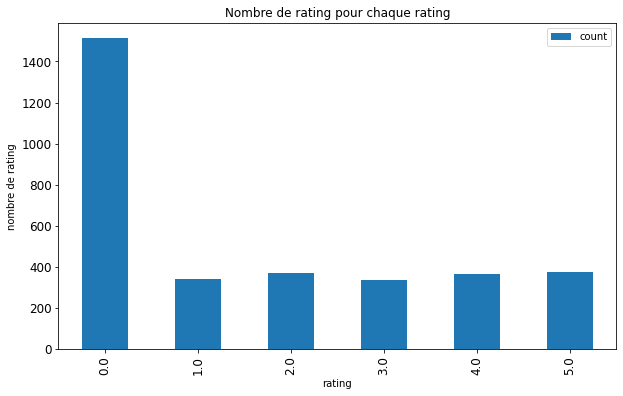

In [8]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(10, 6),
    title='Nombre de rating pour chaque rating',
    fontsize=12,
)
ax.set_xlabel("rating")
ax.set_ylabel("nombre de rating")

In [9]:
df_ratings.head()

,customer,productId,rating
0,1,541,4.0
1,1,540,4.0
2,1,539,5.0
3,1,538,3.0
4,1,537,3.0


In [10]:
# le nombre de rating pour chaque produit
df_products_cnt = pd.DataFrame(df_ratings.groupby('productId').size(), columns=['count'])
df_products_cnt.head()

,count
productId,
48,3
49,3
50,3
51,3
52,3


In [11]:
# le nombre de rating faite par client
df_users_cnt = pd.DataFrame(df_ratings.groupby('customer').size(), columns=['count'])
df_users_cnt.head()

,count
customer,
1,370
2,150
3,480
4,200
6,200


# Entraîner le modèle KNN pour le filtrage collaboratif

In [12]:
# pivoter et créer une matrice product_user
product_user_mat = df_ratings.pivot(index='productId', columns='customer', values='rating').fillna(0)

#référencer un titre du produit par un index
product_to_idx = {
    product: i for i, product in 
    enumerate(list(df_products.set_index('productId').loc[product_user_mat.index].title))
}

# transformer la matrice en matrice scipy sparse
product_user_mat_sparse = csr_matrix(product_user_mat.values)     # (i, j)    nb non null
product_user_mat_sparse.getnnz()     #nombre des éléments non null

1781

In [13]:
product_user_mat.head()

customer,1,2,3,4,6,8
productId,,,,,,
48,1.0,0.0,4.0,0.0,0.0,1.0
49,2.0,0.0,2.0,0.0,0.0,3.0
50,2.0,0.0,4.0,0.0,0.0,5.0
51,4.0,0.0,3.0,0.0,0.0,3.0
52,1.0,0.0,5.0,0.0,0.0,2.0


In [14]:
%env JOBLIB_TEMP_FOLDER=/tmp

# définir le modèle

    # metric='cosine' : la métrique de distance à utiliser ('cosine' : cosine similarity)
    # algorithm='brute' : Algorithme utilisé pour calculer les voisins les plus proches ('brute' : brute-force search)
    # n_jobs=-1 : travail parallèle tous CPU sont utilisés
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

model_knn.fit(product_user_mat_sparse)  # Entraîner le modèle

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

# Utilisation de modèle pour la recommandation de produits

In [17]:
def fuzzy_matching(mapper, fav_product, verbose=True):
    """
    renvoie la correspondance la plus proche. Si aucune correspondance n'est trouvée, retourne None
    
    Parameters
    ----------    
    mapper: dict, mapper le titre du produit à un index du produit

    fav_movie: str, nom du produit entrée par utilisateur
    
    verbose: bool, afficher tous les correspondances possibles si True

    Return
    ------
    index de la correspondance la plus proche
    """
    match_tuple = []
    # obtenir les correspondances
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_product.lower())    # 0< ratio <100  % de compatibilité entre 2 strings
        if ratio >= 70:
            match_tuple.append((title, idx, ratio))
            
    # trier par ratio (dec) 
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    
    if not match_tuple:
        print("Aucune correspondance n'est trouvée")
        return None
    if verbose:
        print('Les correspondances possibles trouvées: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]     # retourne idx de 1er correspondance

# ---------------------------------------------------------------------#

def make_recommendation(model_knn, data, mapper, fav_product, n_recommendations):
    """
    retourne les n produit similaires au produit entrée par l'utilisateur


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: la matrice product-user

    mapper: dict, mapper le  titre du produit à l'index du produit 

    fav_product : str, nom du produit entrée par utilisateur

    n_recommendations: int, top n recommendations

    Return
    ------
    liste des n meilleures produits similaires
    """
    model_knn.fit(data)
    
    # obtenir l'index du produit le plus compatible avec le produit entrée (en terme de caractère)
    print('Vous avez entré le produit:', fav_product)
    idx = fuzzy_matching(mapper, fav_product, verbose=True)
    
    # calculer les distances et trouver les indices des produits plus proche
    print('Démarrage du système de recommandation')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    # obtenir la liste des idx des recommandations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    
    # print recommendations
    print('Recommendations pour {}:'.format(fav_product))
    for i, (idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, avec une distance de "{2}"'.format(i+1, reverse_mapper[idx], dist))

In [18]:
my_favorite = 'Sweater Dress'

make_recommendation(
    model_knn=model_knn,
    data=product_user_mat_sparse,
    fav_product=my_favorite,
    mapper=product_to_idx,
    n_recommendations=3)

Vous avez entré le produit: Sweater Dress
Les correspondances possibles trouvées: ['Sweater Long Dresses', 'Sweater Dress Winter']

Démarrage du système de recommandation
......

Recommendations pour Sweater Dress:
1: Men Color Block Non-slip Sneakers, avec une distance de "0.005915939807891846"
2: Contrast Floral Print Sleeve Top, avec une distance de "0.0034543275833129883"
3: Men Lace-up Decor Wide Fit Sneakers, avec une distance de "0.0020711421966552734"
